In [35]:
import os 
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from pysimx.src.data_types import Order
from pysimx.src.exchange import TOB_Exchange

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [24]:
folder_path = '/Users/jan-gobeli/Code/bi-repo/data/tardis/datasets/'

In [25]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)
    return df

In [26]:
# define folder path
files_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == 'COMPBTC.csv.gz'
    and f.split('_')[1] == 'quotes']
files_list

['binance_quotes_2023-07-02_COMPBTC.csv.gz',
 'binance_quotes_2023-07-05_COMPBTC.csv.gz',
 'binance_quotes_2023-07-04_COMPBTC.csv.gz',
 'binance_quotes_2023-07-03_COMPBTC.csv.gz']

In [27]:
binance_data = get_data(files_list)

100%|██████████| 4/4 [00:00<00:00, 15.24it/s]


In [28]:
binance_data['time'] = pd.to_datetime(binance_data.timestamp, unit='us')
binance_data.set_index('time', inplace=True)

## Open Exchange

In [29]:
# Create new exchange called binance with a average latency of 5000 us and 29% std
binance = TOB_Exchange(latency=[5000, 0.29])
# Were traing one market in this example, so were adding it to the markets
symbol = 'COMPBTC'
binance.add_market(symbol, 'COMP', 'BTC')
# We start with a balance for only BTC 
binance.add_balance('COMP', 0)
binance.add_balance('BTC', 0.1)

# Now we can load the TOB data into the exchange events
lst = binance_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
binance.load_tob(lst, symbol)

## Strategy

In [30]:
# Our signal is a simple top-of-book pressure. 
# If the TOB is dominated by buys (99.9% of the TOB quanitites are buys) then we enter a market buy order
# If the TOB is dominated by sells (0.1% of the TOB quanitites are buys) then we enter a market sell order

def signal(tob):
    bid_pressure = tob['bid_quantity'] / (tob['bid_quantity'] + tob['ask_quantity'])

    if bid_pressure >= 0.999: 
        return 1 
    
    elif bid_pressure <= 0.001: 
        return -1 
    
    else: 
        return 0

In [31]:
# We can now embed this signal into a simple strategy class that runs on every update

class tob_imbalance(): 
    def __init__(self):
        self.symbol = 'COMPBTC'
        self.amount = 4

        self.flag = False

    def run_strategy(self):

        tob = binance.fetch_tob(self.symbol)

        decision = signal(tob)

        if (decision == 1) and not (self.flag): 
            binance.market_order(symbol, self.amount, 1, tob['timestamp'])
            self.flag = True

        elif (decision == -1) and (self.flag): 
            binance.market_order(symbol, self.amount, 0, tob['timestamp'])
            self.flag = False

        else: 
            pass

In [32]:
binance.run_simulation(tob_imbalance)

Trade Executed Trade(trade_id=99, order_id=99, side=1, taker=True, amount=4, price=0.001685, entryTime=1688264478098385.2, eventTime=1688264478098385.2)
Trade Executed Trade(trade_id=100, order_id=100, side=0, taker=True, amount=4, price=0.001676, entryTime=1688264792959414.0, eventTime=1688264792959414.0)
Trade Executed Trade(trade_id=101, order_id=101, side=1, taker=True, amount=4, price=0.001697, entryTime=1688265275208027.5, eventTime=1688265275208027.5)
Trade Executed Trade(trade_id=102, order_id=102, side=0, taker=True, amount=4, price=0.001771, entryTime=1688279399271865.0, eventTime=1688279399271865.0)
Trade Executed Trade(trade_id=103, order_id=103, side=1, taker=True, amount=4, price=0.001762, entryTime=1688280358094269.2, eventTime=1688280358094269.2)
Trade Executed Trade(trade_id=104, order_id=104, side=0, taker=True, amount=4, price=0.001813, entryTime=1688287936021846.5, eventTime=1688287936021846.5)
Trade Executed Trade(trade_id=105, order_id=105, side=1, taker=True, amo

In [33]:
balances = pd.DataFrame(binance.historical_balance)
balances['comp_usd'] = balances.COMP * balances.mid
balances['combined'] = balances.comp_usd + balances.BTC

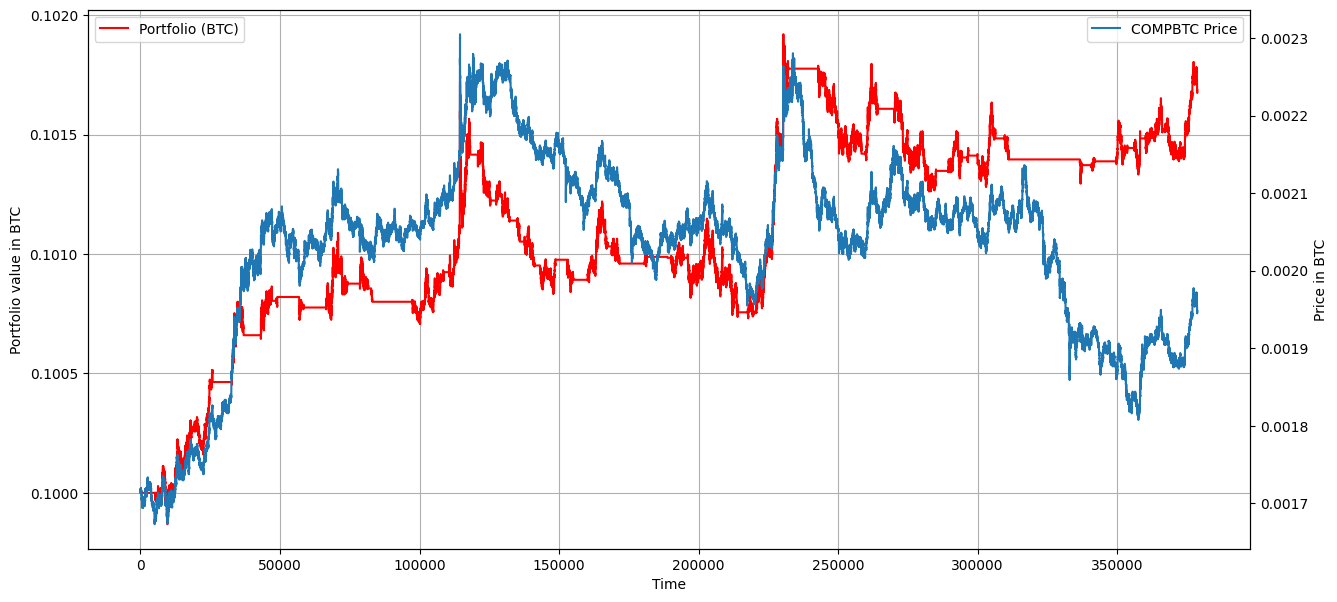

In [41]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot(balances.combined, label='Portfolio (BTC)', color='r')

ax2 = ax.twinx()
ax2.plot(balances.mid, label='COMPBTC Price')
ax.set_xlabel('Time')
ax2.set_ylabel('Price in BTC')
ax.set_ylabel('Portfolio value in BTC')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.grid()